In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

In [3]:
pth = '/Users/nicholascalen/fnc-1/'
train_bodies = pd.read_csv(pth + 'train_bodies.csv').set_index('Body ID')
train_headlines = pd.read_csv(pth + 'train_stances.csv').set_index('Body ID')
train_all = train_headlines.join(train_bodies)

In [4]:
print(len(train_bodies), len(train_headlines)) 

1683 49972


In [5]:
display(train_all.sample(6))
train_all[['Headline','articleBody','Stance']]

,Headline,Stance,articleBody
Body ID,,,
115,Who Is Michael Zehaf-Bibeau? Ottawa Shooter Su...,unrelated,Afghanistan veteran Sam Arnold uploaded this s...
1195,[UPDATED] 11 Men and 0 Women on Tonight's ESPN...,unrelated,The Islamist group Boko Haram has denied claim...
68,Isis video claims to show beheading of British...,unrelated,The Racket Report – KFC Gets Occupational Busi...
1900,Canadian Soldier Shot At Ottawa War Memorial: ...,unrelated,He’s being called a hero for shooting a rampag...
1255,URGENT: ISIS leader Abu Bakr al-Baghdadi alleg...,unrelated,The CBI registered a case against Gurmeet Ram ...
2213,Dog abandoned at railway station with suitcase...,unrelated,"On Tuesday, Apple unveiled its first wearable ..."


(49972, 3)

## What does the text look like - what could be cleaned ? 

### Headlines 

In [347]:
train_headlines.Headline.sample(35).tolist()

['Government fires employee who skipped work for 24 years',
 "Pull the other Un! North Korean dictator has not been seen for weeks because he 'pulled tendon while doing drill with his generals'",
 'Amazon plans a streaming-video alternative',
 'Mexico Says Missing Students Not Found In First Mass Graves',
 'HBO streaming service could launch in April for $15 per month, work on Apple TV',
 'Banksy arrest hoax: US website claims street artist caught in Watford',
 'What was fake on the Internet this week: Obama’s peace prize, pumpkin-spice condoms and insane winter snow',
 'Video Purports to Show Beheading of American Journalist',
 'Islamic State Training Pilots in Military Jets, Monitors Say',
 'Catholic Priest Claims God Is Female After Clinically Dead Experience',
 'IRAQI AND KURDISH MEDIA REPORTS: ISIS FIGHTERS HAVE CONTRACTED EBOLA',
 'Apple Watch battery will require nightly charging',
 'Ottawa investigates reports that Isis has captured Canadian-Israeli woman',
 "Tropical spider bu

Initial list: 

1. lowercase 
2. replace doller values with words so $50 changes to fifty dollars 
3. nouns 
4. companies Apple vs apple 
5. keep '-'s 
6. if 2 adjacent words capitalized push together to form one then lower it (if using ulmfit this will help) 

### Bodies: 

In [348]:
train_bodies.articleBody.sample(35).tolist()

['\'A bunch ate through the ceiling of a sports editor\'s office and crawled all over his desk and left poops on his keyboard\'\n\nNot everyone at magazine publisher Condé Nast was thrilled on hearing the company was going to become the new flagship tenant of the brand new World Trade Centre skyscraper where the Twin Towers once stood. Some felt spooked by the tragic history of the site. They didn’t reckon on rats.\n\nBut one month after decamping from their old HQ off Times Square, the glamorous crews of titles like Vogue and Vanity Fair are waging a daily battle against a positive rat rampage. All employees have been banned from eating at their desks for fear of dispensing inadvertent treats to the roaming rodents.\n\nSources have told the Daily News that Vogue editor Anna Wintour, who likes a world of red carpets and sparkle not droppings and thick tails vanishing into cracks, has refused to show up in her office until the problem is bought under control.\n\nWhile rat sightings are 

Initial list: 

1. remove newline chars
2. remove links 
3. same transforms as above. 
4. keep dates for now 
5. remove file paths, @ symbols , e.t.c. 

Might be interesting to try summerizing the bodies, training on that. Two stage model approach. 

### Observe class counts - Label Distribution 

In [349]:
train_all.Stance.unique().tolist() # class labels

['unrelated', 'agree', 'discuss', 'disagree']

In [350]:
train_all.groupby('Stance').apply(lambda x: len(x) / len(train_all))

Stance
agree        0.073601
disagree     0.016809
discuss      0.178280
unrelated    0.731310
dtype: float64

In [351]:
train_all.groupby('Stance').apply(lambda x: len(x))

Stance
agree         3678
disagree       840
discuss       8909
unrelated    36545
dtype: int64

Pretty unbalanced. Look for evidence a two stage model might help. We have duplicate bodies for the same headline so lets grouby one or the other and look into the classes. 

In [352]:
train_all.groupby(['Headline','Stance']).count()

articleBody
Headline                                           Stance                
"Categorically False": DHS Debunks Right-Wing F... agree                6
                                                   disagree             2
                                                   discuss              5
                                                   unrelated           26
"Oldest Time Capsule" in U.S. Unearthed in Boston  discuss              3
...                                                                   ...
“Axl Rose dead 2014” : Guns N' Roses frontman k... agree                7
                                                   unrelated            8
“Willie Nelson dead 2015” : Guitarist killed by... agree                3
                                                   disagree             1
                                                   unrelated            4

[4171 rows x 1 columns]

Need to form two targets. If one of agree, discuss, disagree, target = 'related' else target = 'unrelated'. 

In [353]:
train_all['target_stage1'] = ''
train_all['target_stage2'] = train_all.Stance
train_all.loc[train_all.Stance == 'unrelated', 'target_stage1'] = 'unrelated'
train_all.loc[train_all.Stance != 'unrelated', 'target_stage1'] = 'related'
train_all.loc[train_all.Stance == 'unrelated', 'target_stage2'] = None
train_all.drop('Stance',inplace=True,axis=1)
train_all.reset_index(inplace=True,drop=True)
train_all.sample(10)

,Headline,articleBody,target_stage1,target_stage2
18121,NASA Raises Doubts About Reports of Nicaraguan...,Experts have raised doubts about whether a lou...,related,agree
12346,ISIS leader dead?,Thousands of social media users are distributi...,related,discuss
22845,White House Fence Jumper Actually Made It Pret...,(Reuters) - Online retailer Amazon.com Inc (AM...,unrelated,None
35279,ISIS Fighters Getting Caught Coming Across the...,NEW YORK — Pope Francis has given hope to gays...,unrelated,None
44194,Isis leader Abu Bakr al-Baghdadi's 'wife and s...,Central Bedfordshire Council has refuted newsp...,unrelated,None
26630,A Spider Lived Inside This Tourist’s Body For ...,Tonight — finally! — ESPN is going to have an ...,unrelated,None
15808,"Sorry, KFC isn't going to be selling weed in C...",Iraqi pilots who have joined Islamic State are...,unrelated,None
32362,British hostage David Haines beheaded by Islam...,New York City continues to seek ways to cut do...,unrelated,None
38040,Report: HBO Now coming to Apple TV next month,"LONDON, Jan 9 – Twitter is abuzz with rumours ...",unrelated,None
45968,Audio recording of Michael Brown being gunned ...,"Here at Consumerist HQ, we were both intrigued...",unrelated,None


### Related vs Unrelated Examples: How was the labeling done? 

In [354]:
sample = train_all.loc[train_all.target_stage1 =='related'].sample(5)

In [355]:
for pair in sample.iterrows(): 
    print('Headline:')
    print(pair[1].Headline)
    print('\nBody:')
    print(pair[1].articleBody)
    print('-'*50)
    print()

Headline:
Missing American journalist reportedly beheaded by Islamic State 

Body:

An American freelance photojournalist missing since being abducted in Syria some 22 months ago was apparently beheaded by an Islamic State militant in a graphic video released Tuesday.

Titled “A Message to America,” the gruesome clip shows a masked militant saw away at the neck of James Wright Foley, a 40-year-old New Hampshire native captured in Binesh, Syria on Thanksgiving Day 2012.

The family, on its "Free James Foley" Facebook page, has yet to confirm his death.

"Please be patient until we all have more information, and keep the Foleys in your thoughts and prayers," the statement reads.

Foley, dressed in orange and kneeling in a desert, reads what appears to be a coerced statement that alludes to recent American airstrikes against the Islamic State in Iraq.

“I call on my friends, family and loved ones to rise up against my real killers, the U.S. government. For what will happen to me is only a

In [356]:
sample = train_all.loc[train_all.target_stage1 =='unrelated'].sample(5)
for pair in sample.iterrows(): 
    print('Headline:')
    print(pair[1].Headline)
    print('\nBody:')
    print(pair[1].articleBody)
    print('-'*50)
    print()

Headline:
Report: Christian Bale Will Play Steve Jobs

Body:
WOBURN, Mass. (AP) — A 113-year-old, shoebox-sized time capsule was removed Thursday from the head of a lion statue where it had long sat, hidden in plain sight, atop one of Boston's most famous landmarks.

When the copper box was carefully pried open, it revealed at least one mystery: a red, hardcover book with no visible title or markings. The contents of the book — and the rest of the items in the box — will remain a mystery for a bit longer, as they were deemed too fragile to remove immediately.

The time capsule's presence at the Old State House had only recently been confirmed. The Bostonian Society, which oversees the building, had expected it to contain a potpourri of photographs and newspaper clippings from the period, along with a missive to future generations penned by a group of Boston journalists.

"I'm absolutely delighted by the conditions inside the box," said Brian LeMay, the society's president, noting littl

Looking like names play and important role in relatedness. Also mentioning a product in body and headline. Basically if same nouns are mentioned they seem to be related. 

Could we add filters additionally? 3 stage maybe? 

Maybe headline and body that have same sentiment are related? Explore. 

### Outliers - Text Length - Look for correlations between Related / Unrelated 

What makes text "related" vs "unrelated"

In [357]:
import re 

def txt_len(text):
    return len(re.sub('[^A-Za-z0-9]+', ' ', text).split())
def preprocess(text):
    return re.sub('[^A-Za-z0-9]+', ' ', text).split()

In [358]:
train_all['len_headline'] = train_all.Headline.apply(txt_len)
train_all['len_bod y'] = train_all.articleBody.apply(txt_len)
train_all['total_len'] = train_all['len_headline'] + train_all['len_body']

In [359]:
train_all.head()

,Headline,articleBody,target_stage1,target_stage2,len_headline,len_body,total_len
0,"Soldier shot, Parliament locked down after gun...",A small meteorite crashed into a wooded area i...,unrelated,None,11,325,336
1,Tourist dubbed ‘Spider Man’ after spider burro...,A small meteorite crashed into a wooded area i...,unrelated,None,11,325,336
2,Luke Somers 'killed in failed rescue attempt i...,A small meteorite crashed into a wooded area i...,unrelated,None,9,325,334
3,BREAKING: Soldier shot at War Memorial in Ottawa,A small meteorite crashed into a wooded area i...,unrelated,None,8,325,333
4,Giant 8ft 9in catfish weighing 19 stone caught...,A small meteorite crashed into a wooded area i...,unrelated,None,24,325,349


In [360]:
def jaccard_similarity(query, document):
    intersection = set(query).intersection(set(document))
    union = set(query).union(set(document))
    return len(intersection)/len(union)

In [361]:
train_all['jaccard_similarity'] = train_all.apply(lambda x: jaccard_similarity(x.Headline, x.articleBody), axis=1)

In [362]:
train_all.groupby('target_stage1')['jaccard_similarity'].mean()

target_stage1
related      0.419124
unrelated    0.397494
Name: jaccard_similarity, dtype: float64

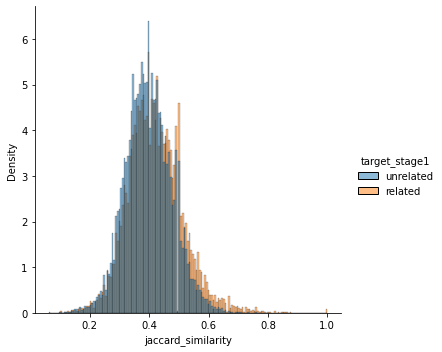

In [363]:
sns.displot(train_all, x="jaccard_similarity", hue="target_stage1", stat="density", common_norm=False)
plt.show()

In [364]:
train_all.groupby('target_stage1')['jaccard_similarity'].min()

target_stage1
related      0.103896
unrelated    0.060606
Name: jaccard_similarity, dtype: float64

In [365]:
train_all.groupby('target_stage1')['jaccard_similarity'].max()

target_stage1
related      1.000000
unrelated    0.769231
Name: jaccard_similarity, dtype: float64

Could be a safe bet to label outside the ranges here. Can we score it differently to get a larger gorup seperation here? 

In [ ]:
from sentence_transformers import SentenceTransformer
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')
sample = train_all.sample(1000)
headline_embeddings = sbert_model.encode(sample['Headline'].tolist())
article_embeddings = sbert_model.encode(sample['articleBody'].tolist())

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3417, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-366-a723d05df951>", line 4, in <module>
    headline_embeddings = sbert_model.encode(sample['Headline'].tolist())
  File "/opt/anaconda3/lib/python3.7/site-packages/sentence_transformers/SentenceTransformer.py", line 157, in encode
    out_features = self.forward(features)
  File "/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/container.py", line 117, in forward
    input = module(input)
  File "/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/module.py", line 727, in _call_impl
    result = self.forward(*input, **kwargs)
  File "/opt/anaconda3/lib/python3.7/site-packages/sentence_transformers/models/Transformer.py", line 51, in forward
    output_states = self.auto_model(**trans_features, return_dict=False)
  File "/opt/anaconda3/lib/python3.7/

In [366]:
from sklearn.metrics.pairwise import cosine_similarity

sample['cosine_similarity'] =0
for i in range(0,len(sample)): 
    sample['cosine_similarity'].iloc[i] = cosine_similarity(headline_embeddings[i,None], article_embeddings[i,None])

ERROR! Session/line number was not unique in database. History logging moved to new session 264


In [367]:
sample.groupby('target_stage1')['cosine_similarity'].min()

target_stage1
related      0.003991
unrelated    0.050279
Name: cosine_similarity, dtype: float64

In [368]:
sample.groupby('target_stage1')['cosine_similarity'].max()

target_stage1
related      0.911139
unrelated    0.909567
Name: cosine_similarity, dtype: float64

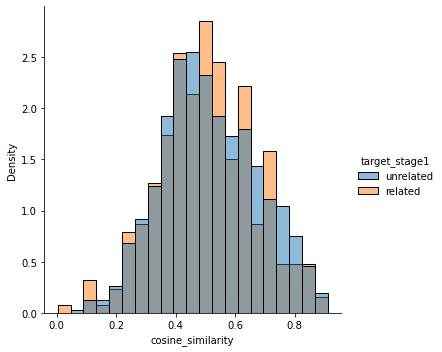

In [369]:
sns.displot(sample, x="cosine_similarity", hue="target_stage1", stat="density", common_norm=False)
plt.show()

Still not a clear boundry. Let's examine if just using the nouns in headline/body play a better role.

### POS Tagging: 

In [86]:
from flair.data import Sentence
from flair.models import SequenceTagger

# load tagger
tagger = SequenceTagger.load("flair/pos-english")


2022-01-27 15:16:50,646 loading file /Users/nicholascalen/.flair/models/pos-english/a9a73f6cd878edce8a0fa518db76f441f1cc49c2525b2b4557af278ec2f0659e.121306ea62993d04cd1978398b68396931a39eb47754c8a06a87f325ea70ac63
Sentence: "I love Berlin ."   [− Tokens: 4  − Token-Labels: "I <PRP> love <VBP> Berlin <NNP> . <.>"]
The following NER tags are found:
Span [1]: "I"   [− Labels: PRP (1.0)]
Span [2]: "love"   [− Labels: VBP (1.0)]
Span [3]: "Berlin"   [− Labels: NNP (0.9999)]
Span [4]: "."   [− Labels: . (1.0)]


In [271]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")

nlp = pipeline("ner", model=model, tokenizer=tokenizer)
example = "My name is Wolfgang and I live in Berlin, pumpkin"

ner_results = nlp(example)
print([x['word'] for x in ner_results])

['Wolfgang', 'Berlin']


In [112]:
def entity(text):
    ner_results = nlp(text)
    return [x['word'] for x in ner_results]

In [113]:
sample['headline_ents'] = sample.Headline.apply(entity)

In [114]:
sample['body_ents'] = sample.articleBody.apply(entity)

In [116]:
sample['jaccard_similarity_nouns'] = sample.apply(lambda x: jaccard_similarity(x.headline_ents, 
                                                                                     x.body_ents), axis=1)

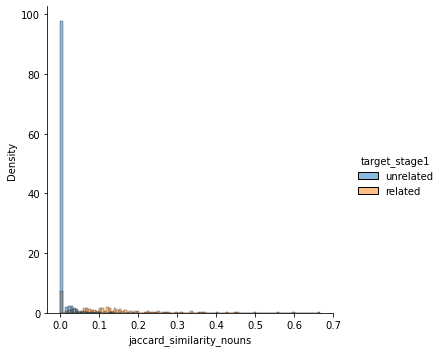

In [118]:
sns.displot(sample, x="jaccard_similarity_nouns", hue="target_stage1", stat="density", common_norm=True)
plt.show()

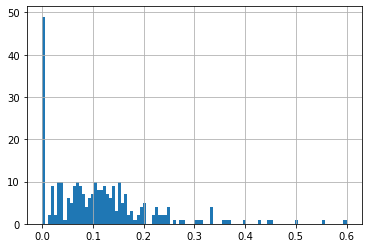

In [316]:
sample.loc[sample.target_stage1 =='related',"jaccard_similarity_nouns"].hist(bins=100)
plt.show()

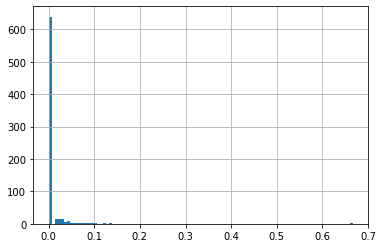

In [317]:
sample.loc[sample.target_stage1 =='unrelated',"jaccard_similarity_nouns"].hist(bins=100)
plt.show()

In [130]:
related = sample.loc[sample.target_stage1 =='related']
display(related.loc[related.jaccard_similarity_nouns < .1])
related.loc[related.jaccard_similarity_nouns < .1].jaccard_similarity_nouns.mean()

,Headline,articleBody,target_stage1,target_stage2,len_headline,len_body,total_len,jaccard_similarity,cosine_similarity,headline_ents,body_ents,jaccard_similarity_nouns
45490,Mexico checks if 43 missing students in mass g...,Authorities unearthed on Saturday unmarked gra...,related,discuss,9,382,391,0.392857,0.783416,[Mexico],"[Mexico, In, ##ak, ##y, Blanco, Guerrero, I, #...",0.038462
26809,"US Drones, Hunting for ISIS Leader, Seen Flyin...",Activists in Al Raqqa have posted images onlin...,related,discuss,11,256,267,0.438596,0.719057,"[US, Dr, ##ones, IS, ##IS, Syrian, Air, ##space]","[Al, Ra, ##q, ##qa, U, ., S, Pre, ##tor, Syria...",0.021739
29883,AWESOME! Canadian Parliament’s Sergeant-at-Arm...,OTTAWA – The gunman who charged into Parliamen...,related,agree,12,376,388,0.545455,0.748735,"[Canadian, Kevin, Vickers]","[O, ##TT, ##A, ##WA, Parliament, Canadian, For...",0.073171
42884,One of 'Taliban Five' in Bowe Bergdahl swap al...,Speculation is mounting that one of the senior...,related,discuss,12,745,757,0.400000,0.515858,"[Taliban, Five, Bow, ##e, Berg, ##dah]","[Taliban, US, CNN, US, Obama, Bow, ##e, Berg, ...",0.089286
22570,"Priest Dies, Wakes Up, Claims God Is a Woman. ...",Description: Fake news / Satire\nCirculating s...,related,discuss,10,607,617,0.350649,0.745644,[God],"[World, ##N, ##ews, ##D, ##ail, ##y, ##R, ##or...",0.021739
...,...,...,...,...,...,...,...,...,...,...,...,...
46394,NYPD to stop arrests for small amounts of mari...,Mayor de Blasio and NYPD Commissioner Bill Bra...,related,discuss,9,666,675,0.283582,0.705911,"[NY, ##PD]","[Mayor, de, B, ##las, ##io, NY, ##PD, Bill, B,...",0.048780
22661,Report: Nearly a Dozen Commercial Airliners Mi...,Nouakchott — The Tripoli airport siege led to ...,related,discuss,17,444,461,0.484848,0.785055,"[Islam, Libyan, Airport]","[No, ##ua, ##k, ##cho, ##tt, Tripoli, Mediterr...",0.000000
12922,WATCH: Bird Launches Airstrike on Putin’s Shou...,"Vox.com, the brainy news-explainer site, has a...",related,disagree,9,197,206,0.433962,0.579539,"[Bird, Launch, ##es, Air, ##st, ##rik, Putin]","[V, ##ox, ., com, Internet, Putin, Russian, Pu...",0.055556
5581,A soldier has been shot at Canada’s war memori...,A man with a rifle shot a soldier standing gua...,related,agree,18,223,241,0.458333,0.776866,[Canada],"[War, Memorial, Ottawa, Parliament, Hill, Alai...",0.000000


0.036725979257261177

In [131]:
unrelated = sample.loc[sample.target_stage1 =='unrelated']
display(unrelated.loc[unrelated.jaccard_similarity_nouns < .1])
unrelated.loc[unrelated.jaccard_similarity_nouns < .1].jaccard_similarity_nouns.mean()

,Headline,articleBody,target_stage1,target_stage2,len_headline,len_body,total_len,jaccard_similarity,cosine_similarity,headline_ents,body_ents,jaccard_similarity_nouns
44572,Video messaging service verifies timing of CNN...,Online reports in jihadi and Palestinian forum...,unrelated,None,9,320,329,0.295082,0.369693,[CNN],"[Palestinian, Gill, Rosenberg, Islamic, State,...",0.000000
15795,Best Christmas present ever? Heartwarming mome...,Iraqi pilots who have joined Islamic State are...,unrelated,None,18,492,510,0.362069,0.444964,[],"[Iraqi, Islamic, State, Syria, UK, Syrian, Obs...",0.000000
32615,UPDATE: BATMAN v SUPERMAN Batmobile Reportedly...,Reports that Islamic State militants in Mosul ...,unrelated,None,11,484,495,0.455882,0.511001,"[BA, ##TM, ##AN, S, ##UP, ##ER, ##MA, ##N, Bat...","[Islamic, State, Mo, ##sul, E, Iraqi, World, H...",0.000000
48193,Taliban member swapped by Obama for Bowe Bergd...,A man’s letter of resignation from his job has...,unrelated,None,14,195,209,0.448980,0.452883,"[Taliban, Obama, Bow, ##e, Berg, ##dah]","[iPhone, Electric, Boogie, Brody, D, B]",0.000000
4177,'Electric Boogie' Developer Leaves Secret Resi...,Holy Motor City gossip! The rumored theft of t...,unrelated,None,16,246,262,0.348485,0.525703,"[Electric, Boogie]","[Motor, City, Bat, ##mobile, Detroit, Detroit,...",0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
1424,DNA test confirms child is IS head Abu Bakr al...,The move comes after the actor's talks with Fo...,unrelated,None,13,292,305,0.482143,0.471648,"[IS, Abu, Ba, ##k, ##r, al, -, Baghdad, ##i]","[Fox, The, Deep, Blue, Goodbye, Leonardo, Di, ...",0.013333
24774,Paul Rudd Is Not the Viral Video Hero Who Tack...,Police will stop arresting people for low-leve...,unrelated,None,15,257,272,0.418182,0.442654,"[Paul, R, ##udd, Hero, Ba, ##sher, Dallas]","[NY, ##PD, Mayor, de, B, ##las, ##io, The, Pos...",0.000000
32131,BATMAN VS. SUPERMAN BATMOBILE STOLEN,Chinese people have been given state advice on...,unrelated,None,5,230,235,0.267857,0.220769,"[BA, ##AN, S, ##UP]","[Chinese, English, CC, ##TV, Western, Chinese,...",0.000000
33668,"Absent from duty for 25 years, CPWD official d...","SANA, Yemen — An American journalist held for ...",unrelated,None,9,348,357,0.387097,0.605763,"[CP, ##WD]","[SA, ##NA, Yemen, American, Al, Qaeda, Yemen, ...",0.000000


0.003706284857527996

Looks like I solved the problem through this EDA. Doing some cleaning, e.t.c might improve things further. But as a baseline we can use some threshold optimization to get a score on the training set that sort of unsupervised in a sense. 

In [182]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

In [210]:
def objective(threshold): 
    print(threshold)
    sample['pred'] ='unrelated'
    sample.loc[sample.jaccard_similarity_nouns > threshold, 'pred'] = 'related'
    return -accuracy_score(sample.target_stage1, sample.pred)

In [218]:
minimize_scalar?

In [219]:
minimize_scalar(objective,bounds=[0,.2],method='Bounded')

0.07639320225002103
0.12360679774997896
0.04721359549995794
0.029179606750063095
0.039813865336892205
0.05835921350012618
0.04068883707497266
0.05147084275039958
0.04934221912517876
0.054101966249684545
0.052475842498527873
0.05065778087482124
0.0501552810007571
0.049844718999242914
0.05034721887330706
0.05046584300227128
0.05053915674585702
0.0505844671312355
0.050612470489442764
0.05062977751661399
0.05064047384765002
0.050647084543785206
0.050651170178686054


     fun: -0.895
 message: 'Solution found.'
    nfev: 23
  status: 0
 success: True
       x: 0.050651170178686054

In [322]:
sample['pred'] ='unrelated'
sample.loc[sample.jaccard_similarity_nouns > 0, 'pred'] = 'related'

In [323]:
def classification_interpretation(y_pred, y_actual): 
    cf_matrix = confusion_matrix(y_actual, y_pred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='BuGn',  linewidths=10)

cf_matrix = confusion_matrix(sample.target_stage1, sample.pred)
classification_interpretation(sample.pred, sample.target_stage1)

from sklearn.metrics import classification_report
target_names = ['related', 'unrelated']
print(classification_report(sample.target_stage1, sample.pred, target_names=target_names))

So we get 90% accuracy on the first task by just using nouns, no cleaning whatsoever. Nice...

### Investigate the Errors:

In [264]:
sample.loc[sample.target_stage1 != sample.pred].head()

,Headline,articleBody,target_stage1,target_stage2,len_headline,len_body,total_len,jaccard_similarity,cosine_similarity,headline_ents,body_ents,jaccard_similarity_nouns,pred
31643,Matt Taibbi on leave of absence from First Loo...,The Nigerian military says it has reached a ce...,unrelated,None,10,154,164,0.368421,0.339919,"[Matt, Tai, ##bb, ##i, First, Look, Media]","[Nigerian, Bo, ##ko, Hara, ##m, BBC, Good, ##l...",0.034483,related
16149,Does Vogue's New Office Have a Rat Infestation?,Doctor in besieged Syrian town reports arrival...,unrelated,None,9,1014,1023,0.295775,0.602405,"[Vogue, New, Office]","[Syrian, Ku, ##rds, Islamic, State, Ko, Syrian...",0.032258,related
6411,"David Haines Beheaded By ISIS, Execution Video...",Fox & Friends got very excited Thursday mornin...,unrelated,None,12,442,454,0.308411,0.559271,"[David, Hai, ##nes, IS, ##IS, Ex, ##ec, ##utio...","[Fox, &, Friends, Jordan, ##ian, Abdullah, Jor...",0.044444,related
16692,'They ate through the ceilings and pooped on t...,(Reuters) - No suspected cases of Ebola have b...,unrelated,None,30,156,186,0.509434,0.496819,"[Vogue, World, Trade, Center, Anna, Win, ##tour]","[Re, ##uters, E, Iraq, Iraqi, World, Health, O...",0.030303,related
45953,"Pumpkin Spice Condoms, And 6 Other Flavors Tha...","Here at Consumerist HQ, we were both intrigued...",related,agree,11,157,168,0.595745,0.536552,"[P, ##kin, S, ##pice, Con]","[Consumer, ##ist, Internet, Du, ##re, ##x, Uni...",0.000000,unrelated


In [265]:
sample.loc[sample.target_stage1 != sample.pred].head().iloc[-1].Headline

'Pumpkin Spice Condoms, And 6 Other Flavors That Aren’t Happening'

In [267]:
sample.loc[sample.target_stage1 != sample.pred].head().iloc[-1].articleBody

'Here at Consumerist HQ, we were both intrigued and horrified when a plausible-looking mockup of a pumpkin spice flavored condom spent the weekend circulating around the Internet. If pumpkin spice gum and bacon condoms can exist, why not? Alas, the wrapper circulating online isn’t real, even though some people kind of want it to be.\nThe image doesn’t look very authentic, but a pumpkin spice condom is just plausible enough that people kept sharing the image. At first, Durex kept speculation alive by not commenting on the matter. Pumpkin spice is hot in the United States, sure, but could the mania support a limited-time holiday-themed prophylactic? Durex does have a selection of fruit-flavored condoms, but no holiday-themed offerings. Should they?\nThe company cleared things up this afternoon with a tweet:\n\nThey’ve THOUGHT about it? Well, that at least puts pumpkin spice condoms closer to existing than fried chicken Oreos.'

In [269]:
sample.loc[sample.target_stage1 != sample.pred].head().iloc[-1].headline_ents

['P', '##kin', 'S', '##pice', 'Con']

In [270]:
sample.loc[sample.target_stage1 != sample.pred].head().iloc[-1].body_ents

['Consumer',
 '##ist',
 'Internet',
 'Du',
 '##re',
 '##x',
 'United',
 'States',
 'Du',
 '##re',
 '##x',
 'Or',
 '##eo']

In [263]:
sample.iloc[0]

Headline                    Video messaging service verifies timing of CNN...
articleBody                 Online reports in jihadi and Palestinian forum...
target_stage1                                                       unrelated
target_stage2                                                            None
len_headline                                                                9
len_body                                                                  320
total_len                                                                 329
jaccard_similarity                                                   0.295082
cosine_similarity                                                    0.369693
headline_ents                                                           [CNN]
body_ents                   [Palestinian, Gill, Rosenberg, Islamic, State,...
jaccard_similarity_nouns                                                    0
pred                                                            

This ends the baseline work for this stage. 

### What factors make text agree/ diagree

In [370]:
sample_stg2 = sample.loc[~sample.target_stage2.isna()]
sample_stg2.groupby('target_stage2').count()

,Headline,articleBody,target_stage1,len_headline,len_body,total_len,jaccard_similarity,cosine_similarity
target_stage2,,,,,,,,
agree,75,75,75,75,75,75,75,75
disagree,20,20,20,20,20,20,20,20
discuss,197,197,197,197,197,197,197,197


In [382]:
import en_core_web_sm

nlp = en_core_web_sm.load()

def cosine_sim(t1, t2): 
    doc1 = nlp(t1)

    doc2 = nlp(t2)

    # cosine similarity
    return doc1.similarity(doc2) 

In [383]:
sample_stg2['cos_sim'] = sample_stg2.apply(lambda x: cosine_sim(x.Headline, x.articleBody), axis=1)

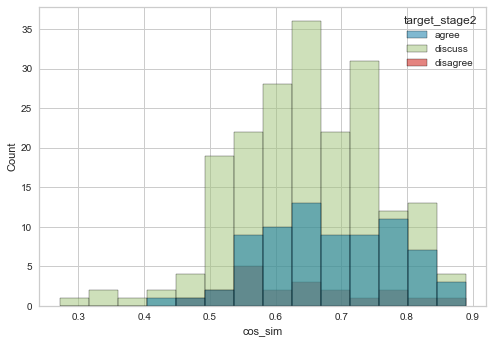

In [387]:
sns.histplot(sample_stg2, x="cos_sim", hue="target_stage2", common_norm=True)
#plt.xlim(0, .2)
plt.show() 

In [374]:
sample_stg2.loc[sample.target_stage2 == 'agree'].head().iloc[0].tolist()[:2]

['Google to buy big chunk of Pacific Shores, iconic Redwood City office park',
 'Google has bought about half of Pacific Shores office park.']

In [372]:
sample_stg2.loc[sample.target_stage2 == 'disagree'].head()

,Headline,articleBody,target_stage1,target_stage2,len_headline,len_body,total_len,jaccard_similarity,cosine_similarity
16568,Tropical spider burrowed under man's skin thro...,Prepare to meet ... mite man.\n\nDoctors remov...,related,disagree,16,189,205,0.519231,0.475603
42489,Aaron Sorkin Confirms Christian Bale Will Play...,It looks like Christian Bale will no longer be...,related,disagree,9,174,183,0.479167,0.602405
26029,Wife Of ISIS Leader Abu Bakr al-Baghdadi Detai...,An Iraqi official denied that a woman detained...,related,disagree,11,623,634,0.462963,0.398564
34515,"Tropical spider burrows under man's skin, live...","Fear not arachnophobes, the story of Bunbury's...",related,disagree,12,634,646,0.531915,0.496410
7621,Female teacher facing sack after making SEX TA...,Lucita Sandoval was not involved in a sex tape...,related,disagree,10,227,237,0.465116,0.614325


In [373]:
sample_stg2.loc[sample.target_stage2 == 'discuss'].head()

,Headline,articleBody,target_stage1,target_stage2,len_headline,len_body,total_len,jaccard_similarity,cosine_similarity
48163,That Was Fast: Christian Bale Bails on Steve J...,"Cristian Bale is eyeing — or i-ing, if you pre...",related,discuss,10,297,307,0.383333,0.733217
14287,Fears journalist James Wright Foley beheaded b...,"“A Message To America,” a video uploaded Tuesd...",related,discuss,15,455,470,0.440678,0.525703
47173,White House Fence Jumper Got Farther Than Prev...,The man who jumped over the White House fence ...,related,discuss,11,216,227,0.500000,0.514483
25215,Nigerians doubtful of girls' release after Bok...,Nigerian officials Friday announced they had a...,related,discuss,10,627,637,0.377049,0.452455
32177,"Meteorite makes big crater in Nicaragua, gover...",(Reuters) - A mysterious late-night blast in t...,related,discuss,8,245,253,0.370370,0.504137


So the previous scoring won't help us here. Is there something about the tone of the texts that might? Let's run sentiment analysis and see!

#### Sentiment:

In [286]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request

# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
 
 
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

tokenizer = AutoTokenizer.from_pretrained(MODEL)

# download label mapping
labels=[]
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)


1) positive 0.8466
2) neutral 0.1458
3) negative 0.0076


In [307]:
def sentiment_uni(text):  
    encoded_input = tokenizer(text, return_tensors='pt', max_length=512, truncation=True)
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)

    ranking = np.argsort(scores)
    label = ranking[::-1][0]
    return labels[label]

def sentiment_multi(text1,text2): 
    encoded_input = tokenizer(text, return_tensors='pt', max_length=512, truncation=True)
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)

    ranking = np.argsort(scores)
    label = ranking[::-1][0]
    return labels[label]

In [308]:
sample['sentiment_headline'] = sample['Headline'].apply(sentiment_uni)
sample['sentiment_body'] = sample['articleBody'].apply(sentiment_uni)

In [309]:
sample['sentiment_both'] = sample.apply(lambda x: sentiment_multi(x.Headline, x.articleBody), axis=1)

In [310]:
sample

,Headline,articleBody,target_stage1,target_stage2,len_headline,len_body,total_len,jaccard_similarity,cosine_similarity,headline_ents,body_ents,jaccard_similarity_nouns,pred,sentiment_headline,sentiment_body,sentiment_both
44572,Video messaging service verifies timing of CNN...,Online reports in jihadi and Palestinian forum...,unrelated,None,9,320,329,0.295082,0.369693,[CNN],"[Palestinian, Gill, Rosenberg, Islamic, State,...",0.000000,unrelated,neutral,neutral,positive
15795,Best Christmas present ever? Heartwarming mome...,Iraqi pilots who have joined Islamic State are...,unrelated,None,18,492,510,0.362069,0.444964,[],"[Iraqi, Islamic, State, Syria, UK, Syrian, Obs...",0.000000,unrelated,positive,neutral,positive
19394,Christian Bale in Talks to Play Steve Jobs in ...,Christian Bale is in talks to play Steve Jobs ...,related,discuss,13,99,112,0.558140,0.794800,"[Christian, Ba, ##le, Talk, ##s, to, Play, Ste...","[Christian, Ba, ##le, Steve, Job, ##s, Aaron, ...",0.242424,related,neutral,neutral,positive
20261,Missing American journalist reportedly beheade...,President Barack Obama spoke Wednesday on the ...,related,discuss,8,255,263,0.480000,0.733217,"[American, Islamic, State]","[Barack, Obama, American, James, Foley, Islami...",0.103448,related,negative,negative,neutral
32615,UPDATE: BATMAN v SUPERMAN Batmobile Reportedly...,Reports that Islamic State militants in Mosul ...,unrelated,None,11,484,495,0.455882,0.511001,"[BA, ##TM, ##AN, S, ##UP, ##ER, ##MA, ##N, Bat...","[Islamic, State, Mo, ##sul, E, Iraqi, World, H...",0.000000,unrelated,neutral,negative,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1424,DNA test confirms child is IS head Abu Bakr al...,The move comes after the actor's talks with Fo...,unrelated,None,13,292,305,0.482143,0.471648,"[IS, Abu, Ba, ##k, ##r, al, -, Baghdad, ##i]","[Fox, The, Deep, Blue, Goodbye, Leonardo, Di, ...",0.013333,related,neutral,neutral,neutral
24774,Paul Rudd Is Not the Viral Video Hero Who Tack...,Police will stop arresting people for low-leve...,unrelated,None,15,257,272,0.418182,0.442654,"[Paul, R, ##udd, Hero, Ba, ##sher, Dallas]","[NY, ##PD, Mayor, de, B, ##las, ##io, The, Pos...",0.000000,unrelated,neutral,neutral,neutral
32131,BATMAN VS. SUPERMAN BATMOBILE STOLEN,Chinese people have been given state advice on...,unrelated,None,5,230,235,0.267857,0.220769,"[BA, ##AN, S, ##UP]","[Chinese, English, CC, ##TV, Western, Chinese,...",0.000000,unrelated,neutral,neutral,positive
33668,"Absent from duty for 25 years, CPWD official d...","SANA, Yemen — An American journalist held for ...",unrelated,None,9,348,357,0.387097,0.605763,"[CP, ##WD]","[SA, ##NA, Yemen, American, Al, Qaeda, Yemen, ...",0.000000,unrelated,negative,negative,neutral


In [312]:
sample_stg2 = sample.loc[~sample.target_stage2.isna()]
sample_stg2.groupby(['target_stage2','sentiment_both']).count()

Headline  articleBody  target_stage1  \
target_stage2 sentiment_both                                         
agree         negative               8            8              8   
              neutral               45           45             45   
              positive              25           25             25   
disagree      neutral               13           13             13   
              positive               8            8              8   
discuss       negative              20           20             20   
              neutral              110          110            110   
              positive              52           52             52   

                              len_headline  len_body  total_len  \
target_stage2 sentiment_both                                      
agree         negative                   8         8          8   
              neutral                   45        45         45   
              positive                  25        25         25   
disagree      neutral                   13        13         13   
              positive                   8         8          8   
discuss       negative                  20        20         20   
              neutral                  110       110        110   
              positive                  52        52         52   

                              jaccard_similarity  cosine_similarity  \
target_stage2 sentiment_both                                          
agree         negative                         8                  8   
              neutral                         45                 45   
              positive                        25                 25   
disagree      neutral                         13                 13   
              positive                         8                  8   
discuss       negative                        20                 20   
              neutral                        110                110   
              positive                        52                 52   

                              headline_ents  body_ents  \
target_stage2 sentiment_both                             
agree         negative                    8          8   
              neutral                    45         45   
              positive                   25         25   
disagree      neutral                    13         13   
              positive                    8          8   
discuss       negative                   20         20   
              neutral                   110        110   
              positive                   52         52   

                              jaccard_similarity_nouns  pred  \
target_stage2 sentiment_both                                   
agree         negative                               8     8   
              neutral                               45    45   
              positive                              25    25   
disagree      neutral                               13    13   
              positive                               8     8   
discuss       negative                              20    20   
              neutral                              110   110   
              positive                              52    52   

                              sentiment_headline  sentiment_body  
target_stage2 sentiment_both                                      
agree         negative                         8               8  
              neutral                         45              45  
              positive                        25              25  
disagree      neutral                         13              13  
              positive                         8               8  
discuss       negative                        20              20  
              neutral                        110             110  
              positive                        52              52

In [315]:
sample.groupby(['target_stage1','sentiment_headline','sentiment_body']).count()

Headline  articleBody  \
target_stage1 sentiment_headline sentiment_body                          
related       negative           negative              91           91   
                                 neutral               40           40   
              neutral            negative              43           43   
                                 neutral               90           90   
                                 positive               6            6   
              positive           neutral                9            9   
                                 positive               2            2   
unrelated     negative           negative             151          151   
                                 neutral              153          153   
                                 positive              17           17   
              neutral            negative             165          165   
                                 neutral              185          185   
                                 positive              13           13   
              positive           negative              16           16   
                                 neutral               17           17   
                                 positive               2            2   

                                                 target_stage2  len_headline  \
target_stage1 sentiment_headline sentiment_body                                
related       negative           negative                   91            91   
                                 neutral                    40            40   
              neutral            negative                   43            43   
                                 neutral                    90            90   
                                 positive                    6             6   
              positive           neutral                     9             9   
                                 positive                    2             2   
unrelated     negative           negative                    0           151   
                                 neutral                     0           153   
                                 positive                    0            17   
              neutral            negative                    0           165   
                                 neutral                     0           185   
                                 positive                    0            13   
              positive           negative                    0            16   
                                 neutral                     0            17   
                                 positive                    0             2   

                                                 len_body  total_len  \
target_stage1 sentiment_headline sentiment_body                        
related       negative           negative              91         91   
                                 neutral               40         40   
              neutral            negative              43         43   
                                 neutral               90         90   
                                 positive               6          6   
              positive           neutral                9          9   
                                 positive               2          2   
unrelated     negative           negative             151        151   
                                 neutral              153        153   
                                 positive              17         17   
              neutral            negative             165        165   
                                 neutral              185        185   
                                 positive              13         13   
              positive           negative              16         16   
                                 neutral               17         17   
                                 positive          

In [333]:
import spacy
import en_core_web_lg
nlp = en_core_web_lg.load()
merge_ents = nlp.create_pipe("merge_entities")
nlp.add_pipe(merge_ents)

In [334]:
doc = nlp("White House dying penis girl marijuana.")

print(f"{'text':{8}} {'POS':{6}} {'TAG':{6}} {'Dep':{6}} {'POS explained':{20}} {'tag explained'} ")
for token in doc:
    print(f'{token.text:{8}} {token.pos_:{6}} {token.tag_:{6}} {token.dep_:{6}} {spacy.explain(token.pos_):{20}} {spacy.explain(token.tag_)}')

text     POS    TAG    Dep    POS explained        tag explained 
White House PROPN  NNP    nmod   proper noun          noun, proper singular
dying    VERB   VBG    amod   verb                 verb, gerund or present participle
penis    NOUN   NN     compound noun                 noun, singular or mass
girl     NOUN   NN     compound noun                 noun, singular or mass
marijuana NOUN   NN     ROOT   noun                 noun, singular or mass
.        PUNCT  .      punct  punctuation          punctuation mark, sentence closer


In [335]:
accepted = ['PERSON','NORP','FAC','ORG','GPE','LOC','PRODUCT','EVENT',
           'WORK_OF_ART','LAW','LANGUAGE','DATE','MONEY', 'NOUN','PROPN']

def noun_tag(text): 
    text = " ".join([x.lemma_ for x in [y 
                                          for y
                                          in nlp(text) 
                                          if not y.is_stop and y.pos_ != 'PUNCT' ]])
    doc = nlp(text)
    return [X.text.lower() for X in doc if X.ent_type_ in accepted or X.pos_ in accepted] 

In [343]:
noun_tag("Fence-jumper got farther into White House")

['fence', 'jumper', 'white house']